# 뉴스기사 분류모델
## #01. 형태소 분석엔진 설치 (colab)



In [1]:

# !git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
# !bash Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab_light_220429.sh


## #02. 패키지 참조


In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten,GRU
from tensorflow.keras.datasets import imdb
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
import requests
from tensorflow.keras.utils import to_categorical
# 토큰화 패키지
from tensorflow.keras.preprocessing.text import Tokenizer
 # 문장 길이를 통일 시키는 용도
from tensorflow.keras.preprocessing.sequence import pad_sequences

from konlpy.tag import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

AttributeError: module '_MeCab' has no attribute 'delete_Path'

## #03. 데이터 셋 준비
### 뉴스기사 데이터셋

In [3]:
origin = pd.read_excel('뉴스기사_병합.xlsx')
origin.head()


,Unnamed: 0,category,content,중복
0,0,"IT,과학","SKT·SKB·넷플릭스, 망 사용료 소송 취하…분쟁 마침표",NaN
1,1,"IT,과학",넷플릭스와 SK텔레콤·SK브로드밴드가 2020년 시작한 지난한 법정 다툼을 끝냈다....,NaN
2,2,"IT,과학",앞서 SKB는 넷플릭스 트래픽이 매년 폭증하면서 전송 비용 부담이 막대하지만 넷플릭...,NaN
3,3,"IT,과학",SKT·SKB와 넷플릭스가 화해 모드로 들어가면서 그간 인터넷TV(IPTV) 3사 ...,NaN
4,4,"IT,과학",다만 양측은 망 사용료 지불 등 구체적인 계약 내용에 대해서는 함구했다. 최환석 S...,NaN


### 불용어 데이터 셋


In [4]:
r = requests.get("https://data.hossam.kr/korean_stopwords.txt")
r.encoding = 'utf-8'
stopwords = r.text.split("\n")
print(stopwords)

['이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나', '사람', '주', '아니', '등', '같', '우리', '때', '년', '가', '한', '지', '대하', '오', '말', '일', '그렇', '위하', '때문', '그것', '두', '말하', '알', '그러나', '받', '못하', '일', '그런', '또', '문제', '더', '사회', '많', '그리고', '좋', '크', '따르', '중', '나오', '가지', '씨', '시키', '만들', '지금', '생각하', '그러', '속', '하나', '집', '살', '모르', '적', '월', '데', '자신', '안', '어떤', '내', '내', '경우', '명', '생각', '시간', '그녀', '다시', '이런', '앞', '보이', '번', '나', '다른', '어떻', '여자', '개', '전', '들', '사실', '이렇', '점', '싶', '말', '정도', '좀', '원', '잘', '통하', '소리', '놓', '!', '"', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '...', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ';', '<', '=', '>', '?', '@', '\\', '^', '_', '`', '|', '~', '·', '—', '——', '‘', '’', '“', '”', '…', '、', '。', '〈', '〉', '《', '》', '가', '가까스로', '가령', '각', '각각', '각자', '각종', '갖고말하자면', '같다', '같이', '개의치않고', '거니와', '거바', '거의', '것', '것과 같이', '것들', '게다가', '게우다', '겨우', '견지에서', '결과에 이르다', '결국', '결론을 낼 수 있다', '겸사겸사', '고려하면', '고로', '곧', '공

## #04. 데이터 전처리
### 뉴스기사에서 영어 특수무자를 제거하고 한글맘ㄴ 남기기


In [5]:
df = origin.copy()

In [6]:


## 한글을 제외한 나머지글자들을 빈 문자열로 대체

df['content'] = df['content'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","",regex=True)
df['content'].replace('',np.nan,inplace=True)

# 전체 데이터 셋 크기 확인
print('데이터 크기: ', df['content'].shape)

# 결측치 확인
print('결측치 크기: ', df['content'].isna().sum())

데이터 크기:  (62326,)
결측치 크기:  450


In [7]:
df.drop('중복',axis=1,inplace=True)

In [8]:
df.head()

,Unnamed: 0,category,content
0,0,"IT,과학",넷플릭스 망 사용료 소송 취하분쟁 마침표
1,1,"IT,과학",넷플릭스와 텔레콤브로드밴드가 년 시작한 지난한 법정 다툼을 끝냈다 일 오전 양측은 ...
2,2,"IT,과학",앞서 는 넷플릭스 트래픽이 매년 폭증하면서 전송 비용 부담이 막대하지만 넷플릭스가 ...
3,3,"IT,과학",와 넷플릭스가 화해 모드로 들어가면서 그간 인터넷 사 중 유일하게 플랫폼 내에서 ...
4,4,"IT,과학",다만 양측은 망 사용료 지불 등 구체적인 계약 내용에 대해서는 함구했다 최환석 경...


In [9]:
df.dropna(inplace=True)
print('결측치 크기: ', df['content'].isna().sum())

결측치 크기:  0


### 종속변수 라벨링

In [10]:
category = list(df['category'].unique())
category

['IT,과학', '경제', '사회', '생활,문화', '세계', '정치']

종속변수 값의 종류를 딕셔서니로 변환

In [11]:
cate_dict = {}
for i, v in enumerate(category):
    cate_dict[v] = i
    
cate_dict

{'IT,과학': 0, '경제': 1, '사회': 2, '생활,문화': 3, '세계': 4, '정치': 5}

#### 종속변수 라벨링


In [12]:
df['category'] = df['category'].map(cate_dict)
df['category'].unique()

array([0, 1, 2, 3, 4, 5], dtype=int64)

### 뉴스기사 형태소 분석

In [13]:
import sys

In [21]:
# if sys.platform == 'win32':
#     mecab = Mecab(dicpath="C:\\mecab\\mecab-ko-dic")
# else:
#     mecab = Mecab()
mecab = Mecab(dicpath="C:\\mecab\\mecab-ko-dic")
# 문장 내 형태소들을 저장할 리스트
word_set = []

# 기사내용에 대한 반복처리
for i , v in enumerate(df['content']):
    morphs = mecab.morphs(v)
    # print(morphs)
    # 형태소 분석 결과에서 불용어를 제외한 별도의 리스트로 생성

    confirm_words =[]
    for j in morphs:
        if j not in stopwords:
            confirm_words.append(j)

    # 불용어를 제외한 형태소 리스트를 통째로 word_Set에 저장ㅇ함
    # -> word_Set 은 2차원 리스트가 된다ㅏ. 1차원이 기사 하나 단위
    word_set.append(confirm_words)

word_set[:3]

[['넷플릭스', '망', '사용료', '소송', '취하', '분쟁', '마침표'],
 ['넷플릭스',
  '텔레콤',
  '브로드밴드',
  '시작',
  '지난',
  '법정',
  '다툼',
  '끝냈',
  '다',
  '오전',
  '양측',
  '은',
  '망',
  '사용료',
  '관련',
  '소송',
  '취하',
  '고',
  '분쟁',
  '종결',
  '했',
  '다',
  '인공지능',
  '기술',
  '활용',
  '해',
  '고객',
  '편익',
  '강화',
  '위한',
  '전략',
  '파트너',
  '십',
  '체결',
  '며',
  '협력',
  '관계',
  '구축',
  '기',
  '했',
  '다'],
 ['앞서',
  '는',
  '넷플릭스',
  '트래픽',
  '매년',
  '폭',
  '증하',
  '면서',
  '전송',
  '비용',
  '부담',
  '막대',
  '넷플릭스',
  '망',
  '사용료',
  '협상',
  '응하',
  '는다며',
  '방송',
  '통신',
  '위원회',
  '재정',
  '신청',
  '했',
  '다',
  '넷플릭스',
  '는',
  '망',
  '사용료',
  '지불',
  '할',
  '의무',
  '다며',
  '서울',
  '지방',
  '법원',
  '채무',
  '부존',
  '재',
  '확인',
  '소송',
  '제기',
  '했',
  '다',
  '심',
  '법원',
  '은',
  '손',
  '줬',
  '다',
  '이후',
  '넷플릭스',
  '항소',
  '고',
  '반소',
  '제기',
  '했',
  '파트너십',
  '체결',
  '싸움',
  '끝났',
  '다']]

### 형태소 토큰화

#### 전체 단어에 대한 토큰화

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(word_set)

print(f'전체 단어의 수 {len(tokenizer.word_index)}')

전체 단어의 수 18795


### 3회 이상 자주 등장하는 단어의 수 구하기ㅏ

In [25]:
# 사용 빈도가 높다고 판단할 등장회수
threshold = 3

# 전체 단어의 수 
total_cnt = len(tokenizer.word_index)

# 등장 빈도수가 threshold 보다 작은 단어의 갯수
rare_cnt = 0 
# 훈련 데이터의 전체 단어 빈도수 총합
total_freq = 0

# 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합
rare_freq = 0

# 단어와 빈도수의 쌍을 key, value로 받는다
for key,value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    # 단어의 등장 빈도수가 threshold 보다 작으면
    if (value < threshold):
        rare_cnt +=1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 미만인 희귀 단어의 수: %s' % (threshold, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

# 자주 등장하는 단어 집합의 크기 구하기 -> 이 값이 첫 번째 학습층의 input 수가 된다.
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :', vocab_size)

단어 집합(vocabulary)의 크기 : 18795
등장 빈도가 3번 미만인 희귀 단어의 수: 4128
단어 집합에서 희귀 단어의 비율: 21.963288108539505
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.37056865242728004
단어 집합의 크기 : 14669


### 자주 등장하는 단어를 제외한 나머지 단어를 oov로 처리하여 최종 토큰화

In [26]:
tokenizer = Tokenizer(vocab_size,oov_token="OOV")
tokenizer.fit_on_texts(word_set)
token_set = tokenizer.texts_to_sequences(word_set)
print('토큰의 크기', len(token_set))

토큰의 크기 61876


### 토큰화 결과의 길이 0인 항목 찾기

In [30]:
# 토큰화 결과 길이가 0 인 항목의 index 찾기
drop_target_index = []

for i,v in enumerate(token_set):
    if len(v)<1:
        drop_target_index.append(i)


print("길이가 0인 항목의 수: ", len(drop_target_index))

print("길이가 0인 항목의 인덱스 모음: ", drop_target_index)


길이가 0인 항목의 수:  94
길이가 0인 항목의 인덱스 모음:  [9317, 9757, 9759, 9762, 9768, 10204, 12973, 13126, 13128, 13131, 13137, 14613, 16798, 16800, 16803, 16809, 19102, 19104, 19107, 19113, 19268, 24799, 24802, 24807, 24811, 24818, 24823, 24826, 24831, 24832, 24834, 24835, 24837, 24839, 24840, 24842, 24843, 24845, 24846, 24848, 24849, 24851, 24853, 24854, 24856, 24858, 24860, 24861, 24863, 24864, 24866, 24868, 24869, 24871, 24873, 24874, 24876, 24878, 24880, 24882, 24884, 24885, 24887, 24889, 24891, 24893, 24895, 24896, 24898, 24900, 24902, 24904, 24906, 24907, 24909, 24910, 24912, 24913, 24915, 24917, 24919, 24920, 24922, 24924, 49555, 49564, 51986, 51995, 54686, 54700, 55425, 55439, 56225, 56239]


### 토큰화 결과의 길이가 0인 항목 삭제

In [31]:
token_set2 = np.asarray(token_set,dtype='object')


### 토큰화 결과에서 길이가 0인 항목을 삭제


In [33]:
# 토큰 결과에서 해당 위치의 항목들을 삭제한다.
fill_token_set = np.delete(token_set2,drop_target_index,axis=0)
# 종속변수에서도 같은 위치의 항목들을 삭제해야 한다.
label_set = np.delete(df['category'].values,drop_target_index,axis=0)

print("독립변수(덧글) 데이터 수: ", len(fill_token_set))
print("종속변수(레이블) 데이터 수: ", len(label_set))

독립변수(덧글) 데이터 수:  61782
종속변수(레이블) 데이터 수:  61782


## #05. 탐색적 데이터 분석

### 1) 각 문장별로 몇개의 단어를 포함하고 있는지 확인

In [35]:
word_count = []
for s in fill_token_set:
    word_count.append(len(s))
max_word_count = max(word_count)
min_word_count = min(word_count)

print('기사의 최대 단어수 :',max_word_count)
print('기사의 최소 단어수 :',min_word_count)


기사의 최대 단어수 : 234
기사의 최소 단어수 : 1


### 2) 히스토그램으로 단어 분포수 확인


c:\Users\Hamin\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Hamin\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


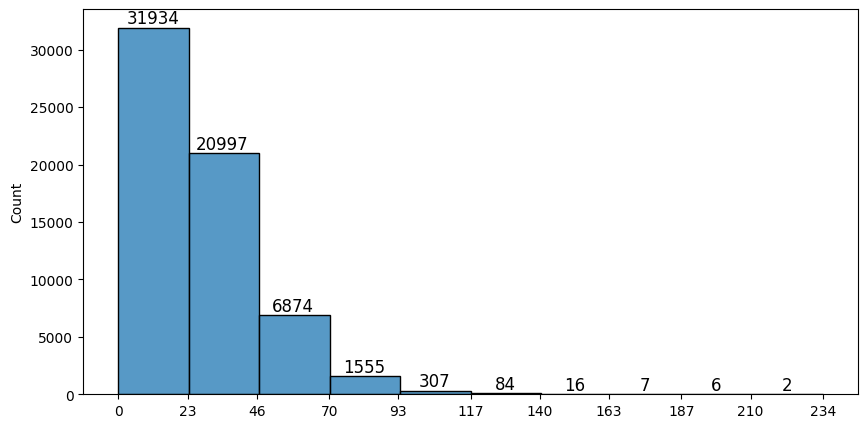

In [39]:
# 히스토그램의 범위 산정
hist_values, hist_bins = np.histogram(word_count, range=(0, max_word_count), bins=10)
hist_bins = hist_bins.astype(np.int64)

plt.figure(figsize=(10, 5))
sns.histplot(word_count, bins=10, binrange=(0, max_word_count))
plt.xticks(hist_bins, hist_bins)

for i, v in enumerate(hist_values):
    x = hist_bins[i] + ((hist_bins[i+1] - hist_bins[i]) / 2)
    plt.text(x=x, y=v, s=str(v), fontsize=12, verticalalignment='bottom', horizontalalignment='center')

plt.show()
plt.close()

## #06. 데이터 셋 분할


In [40]:
np.random.seed(156)


### 패딩처리

In [41]:
max_word_count = max(word_count)
pad_token_set = pad_sequences(fill_token_set,maxlen=max_word_count)

pad_token_set


array([[    0,     0,     0, ...,  1274,   878,  6300],
       [    0,     0,     0, ...,    12,     5,     3],
       [    0,     0,     0, ...,  6640, 10126,     3],
       ...,
       [    0,     0,     0, ...,     8,   447,   152],
       [    0,     0,     0, ...,     0,     0,   462],
       [    0,     0,     0, ...,     0,     0,  1496]])

In [43]:
x_train,x_test,y_train,y_test = train_test_split(pad_token_set,label_set,test_size=0.3)
x_train.shape, x_test.shape,y_train.shape,y_test.shape

((43247, 234), (18535, 234), (43247,), (18535,))

#### 종속변수 one - hot -encoding 


In [46]:
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)
print(y_test_onehot)

[[0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]


## #07. 모델 개발


In [47]:
model = Sequential()
# input_dim의 크기는 토큰 생성시 지정한 최대 단어수(vocab_size)와 동일하게 설정
# output_dim의 크기는 input_dim보다 작은 값 중에서 설정

model.add(Embedding(input_dim = vocab_size,output_dim=(64)))
model.add(GRU(128))
model.add(Dense(6,activation = 'softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          938816    
                                                                 
 gru (GRU)                   (None, 128)               74496     
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 1,014,086
Trainable params: 1,014,086
Non-trainable params: 0
_________________________________________________________________
None


### 학습하기

In [48]:
# 파일이 저장될 경로(폴더) 지정 (한글,공백이 포함되어 있을 경우 에러 발생함)
if sys.platform == 'win32':
    checkpoint_path = "D:\\tensorflow_checkpoint\\cp-{epoch:04d}-ckpt"
else:
    checkpoint_path = "./model07-cp-{epoch:04d}-ckpt"

In [ ]:
result = model.fit(x_train, y_train_onehot, epochs=500, validation_data=(x_test, y_test_one_hot), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True)
])